In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3050 Laptop GPU
Mon Mar 14 19:23:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P3     9W /  N/A |    105MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
  

# Creating training datasets

In [2]:
import pandas as pd
import numpy as np
from typing import List
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

In [3]:
class CustomDataset:
    def __init__(
        self,
        name: str,
        train: List[pd.DataFrame],
        test: List[pd.DataFrame],
        label_list: List[str],
    ):
        """Class to hold and structure datasets.

        Args:

        name (str): holds the name of the dataset so we can select it later
        train (List[pd.DataFrame]): holds training pandas dataframe with 2 columns ["text","label"]
        test (List[pd.DataFrame]): holds testing pandas dataframe with 2 columns ["text","label"]
        label_list (List[str]): holds the list  of labels
        """
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [4]:
# This will hold all the downloaded and structred datasets
all_datasets= []
DATA_COLUMN = "text"
LABEL_COLUMN = "dialect"

In [5]:
df_dialect = pd.read_csv("dialect_dataset_modified.csv")

df_dialect = df_dialect[["text","dialect"]]  # we are interested in text and dialect only
df_dialect.columns = [DATA_COLUMN, LABEL_COLUMN]
print(df_dialect[LABEL_COLUMN].value_counts())

label_list_dialect = list(df_dialect[LABEL_COLUMN].unique())
print(label_list_dialect)

train_dialect, test_dialect = train_test_split(df_dialect, test_size=0.1, random_state=42, stratify=df_dialect[LABEL_COLUMN] )

print("Training length: ", len(train_dialect))
print("Testing length: ", len(test_dialect))

data_dialect = CustomDataset("Dialect", train_dialect, test_dialect, label_list_dialect)

EG    57636
PL    43742
KW    42109
LY    36499
QA    31069
JO    27921
LB    27617
SA    26832
AE    26296
BH    26292
OM    19116
SY    16242
DZ    16183
IQ    15497
SD    14434
MA    11539
YE     9927
TN     9246
Name: dialect, dtype: int64
['IQ', 'LY', 'QA', 'PL', 'SY', 'TN', 'JO', 'MA', 'SA', 'YE', 'DZ', 'EG', 'LB', 'KW', 'OM', 'SD', 'AE', 'BH']
Training length:  412377
Testing length:  45820


# Trainer

In [6]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import copy

from arabert.preprocess import ArabertPreprocessor, never_split_tokens
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

In [7]:
# "bert-base-arabertv2" with FarasaSegmenter or use "bert-base-arabertv02" for no FarasaSegmenter or use apply_farasa_segmentation=True
model_name = 'aubmindlab/bert-base-arabertv02' # we are going to use the twitter AraBERT since it has emojis and dialects

In [8]:
arabic_prep = ArabertPreprocessor(model_name)

data_dialect.train[DATA_COLUMN] = data_dialect.train[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))
data_dialect.test[DATA_COLUMN] = data_dialect.test[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))  

In [9]:
# Sanity check on the dataset
list(data_dialect.train[DATA_COLUMN][0:10])

['[مستخدم] بل بل بل . . ضاحي سؤال . . متى بتنتحر ؟',
 '[مستخدم] واايي . . انا افخر والله',
 '[مستخدم] مايشوف شر # حكيم الخليج',
 '[مستخدم] قلتلة عنهم يقول وينهم يحسبنهم بالشارع',
 'بحس الناس كلها بتنام بالليل صايره ! غريب .',
 '[مستخدم] مزبوط هدا اللي نقول فيه',
 '[مستخدم] انا بالله لو سمحت',
 '[مستخدم] فال انفا بعين دياب',
 'اتصدف في # إنستغرام بحسابات ما اذكرني ضفتها ولا اذكرها ضافتني يعني جديدة علي اول مرة اشوفها وهالشي زاد هالفترة بشكل ملحوظ حد واجه نفس الموضوع ؟',
 '[مستخدم] سما . . رايك انك ماتنتخبش تصبح تبع برك حتى ولو كان قناعة هك ! ! الكلام موجه لصاحب التسمية ! اما انت اختي شكرا على التنوير']

Now we need to check the tokenized sentence length to decide on the maximum sentence length value

In [10]:
tok = AutoTokenizer.from_pretrained(model_name, 
                                    do_lower_case=False, 
                                    do_basic_tokenize=True,
                                    never_split=never_split_tokens)

Training Sentence Lengths: 


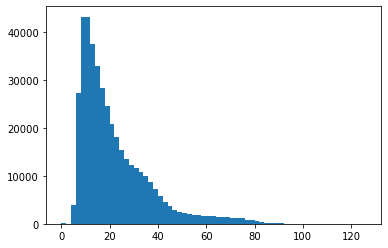

Testing Sentence Lengths: 


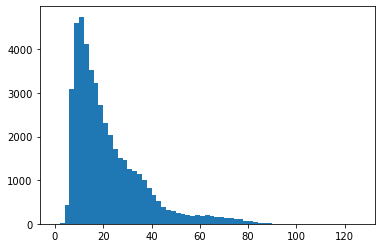

In [11]:
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in data_dialect.train[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in data_dialect.test[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

Let's select 100 as our maximum sentence length, and check how many sequences will be truncated

In [12]:
max_len = 32

In [13]:
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in data_dialect.test[DATA_COLUMN].to_list()]))

print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in data_dialect.test[DATA_COLUMN].to_list()]))

Truncated training sequences:  8437
Truncated testing sequences:  8437


8437 out of ~45000 for testing isn't bad, as to make training faster for 16 batch size to work

Now let's create a classification dataset to load the data

In [14]:
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
        super(ClassificationDataset).__init__()
        """
        Args:
        text (List[str]): List of the training text
        target (List[str]): List of the training labels
        tokenizer_name (str): The tokenizer name (same as model_name).
        max_len (int): Maximum sentence length
        label_map (Dict[str,int]): A dictionary that maps the class labels to integer
        """
        self.text = text
        self.target = target
        self.tokenizer_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                                       do_lower_case=False, 
                                                       do_basic_tokenize=True,
                                                       never_split=never_split_tokens)
        self.max_len = max_len
        self.label_map = label_map
      

    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = str(self.text[item])
        text = " ".join(text.split())
        
        inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True
        )      
        return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [15]:
label_map = { v:index for index, v in enumerate(data_dialect.label_list) }
print(label_map)

train_dataset = ClassificationDataset(
    data_dialect.train[DATA_COLUMN].to_list(),
    data_dialect.train[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    data_dialect.test[DATA_COLUMN].to_list(),
    data_dialect.test[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

{'IQ': 0, 'LY': 1, 'QA': 2, 'PL': 3, 'SY': 4, 'TN': 5, 'JO': 6, 'MA': 7, 'SA': 8, 'YE': 9, 'DZ': 10, 'EG': 11, 'LB': 12, 'KW': 13, 'OM': 14, 'SD': 15, 'AE': 16, 'BH': 17}


Check the dataset output

In [16]:
print(next(iter(train_dataset)))

InputFeatures(input_ids=[2, 7, 549, 549, 549, 20, 20, 40798, 3708, 20, 20, 6735, 4017, 58987, 183, 105, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], label=2)


Create a function that return a pretrained model ready to do classification

In [17]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

In [18]:
def compute_metrics(p): #p should be of type EvalPrediction
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)
    #print(classification_report(p.label_ids,preds))
    #print(confusion_matrix(p.label_ids,preds))
    macro_f1 = f1_score(p.label_ids,preds,average='macro')
    #macro_precision = precision_score(p.label_ids,preds,average='macro')
    #macro_recall = recall_score(p.label_ids,preds,average='macro')
    acc = accuracy_score(p.label_ids,preds)
    return {       
      'macro_f1' : macro_f1,
      'accuracy': acc
    }

In [19]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=False # turned from True to False
    torch.backends.cudnn.benchmark = False

# Regular Training

In [ ]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

In [20]:
training_args = TrainingArguments( 
    output_dir= "./train",    
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = True, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 1,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

Create the trainer

In [21]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

In [22]:
#start the training
trainer.train()

***** Running training *****
  Num examples = 412377
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 12887


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
1,1.479500,1.416772,0.515964,0.549171


***** Running Evaluation *****
  Num examples = 45820
  Batch size = 128
Saving model checkpoint to ./train\checkpoint-12887
Configuration saved in ./train\checkpoint-12887\config.json
Model weights saved in ./train\checkpoint-12887\pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train\checkpoint-12887 (score: 0.51596389143443).


TrainOutput(global_step=12887, training_loss=1.6330110359443504, metrics={'train_runtime': 2963.9778, 'train_samples_per_second': 139.13, 'train_steps_per_second': 4.348, 'total_flos': 6782283415990656.0, 'train_loss': 1.6330110359443504, 'epoch': 1.0})

Save the model, the tokenizer and the config

In [23]:
inv_label_map = { v:k for k, v in label_map.items()}
print(inv_label_map)
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map
trainer.save_model("output_dir")
train_dataset.tokenizer.save_pretrained("output_dir")

Saving model checkpoint to output_dir
Configuration saved in output_dir\config.json


{0: 'IQ', 1: 'LY', 2: 'QA', 3: 'PL', 4: 'SY', 5: 'TN', 6: 'JO', 7: 'MA', 8: 'SA', 9: 'YE', 10: 'DZ', 11: 'EG', 12: 'LB', 13: 'KW', 14: 'OM', 15: 'SD', 16: 'AE', 17: 'BH'}


Model weights saved in output_dir\pytorch_model.bin
tokenizer config file saved in output_dir\tokenizer_config.json
Special tokens file saved in output_dir\special_tokens_map.json


('output_dir\\tokenizer_config.json',
 'output_dir\\special_tokens_map.json',
 'output_dir\\vocab.txt',
 'output_dir\\added_tokens.json',
 'output_dir\\tokenizer.json')